### Statistical Predictive Models

#### The task is to aggregate a dataset for a driver for a specific race and then design a timeseries forecast model to predict next 5 laps' lap times.

In [256]:
import pandas as pd
import numpy as np

### Read the data and basic statistics

In [339]:
results_df = pd.read_csv('race_ts_updated/data_files/results.csv')

In [340]:
results_df = results_df.drop(results_df[results_df['rank'] == '0'].index)
df = results_df[(results_df['statusId'] == 1)].sort_values(['rank','fastestLapSpeed'])

In [341]:
#Get the driver_ids which were top ranked and fastest
print(df.head())

       resultId  raceId  driverId  constructorId number  grid position  \
22636     22640     931       817              9      3     4        5   
23022     23027     953         1            131     44     3        1   
116         117      23         8              6      1     2        9   
21820     21823     885        20              9      1     3        2   
20897     20900     846        17              9      2     3        4   

      positionText  positionOrder  points  laps         time milliseconds  \
22636            5              5    10.0    78      +13.608      6572028   
23022            1              1    25.0    78  1:59:29.133      7169133   
116              9              9     0.0    76      +33.792      7276534   
21820            2              2    18.0    78       +3.888      8275944   
20897            4              4    12.0    78      +23.101      7801474   

      fastestLap rank fastestLapTime fastestLapSpeed  statusId  
22636         74    1      

In [346]:
#Descriptive Stats
columns = ['points','laps']
for col in columns:
    print("The descriptive statistics of the drivers are as follows: ", df[col].describe())
    print()

The descriptive statistics of the drivers are as follows:  count    7225.000000
mean        6.305506
std         5.963277
min         0.000000
25%         2.000000
50%         5.000000
75%         9.000000
max        50.000000
Name: points, dtype: float64

The descriptive statistics of the drivers are as follows:  count    7225.000000
mean       62.724983
std        22.759031
min        12.000000
25%        53.000000
50%        59.000000
75%        71.000000
max       200.000000
Name: laps, dtype: float64



### We can chose driver ID 817 and 1 for our test study as they are the fastest lap speed

In [257]:
# Load the CSV files into DataFrames
lap_times_df = pd.read_csv('race_ts_updated/data_files/lap_times.csv')
pit_stops_df = pd.read_csv('race_ts_updated/data_files/pit_stops.csv')

In [347]:
# Filter the data
race_id = 1095  # Example race ID for Brazilian Grand Prix 2022
driver_id = 1  # Example driver ID
lap_times_df = lap_times_df[(lap_times_df['raceId'] == race_id) & (lap_times_df['driverId'] == driver_id)]
pit_stops_df = pit_stops_df[(pit_stops_df['raceId'] == race_id) & (pit_stops_df['driverId'] == driver_id)]

In [348]:
print(lap_times_df)

        raceId  driverId  lap  position      time  milliseconds
535819    1095         1    1         2  1:30.833         90833
535820    1095         1    2         2  1:54.748        114748
535821    1095         1    3         2  2:00.447        120447
535822    1095         1    4         2  1:59.697        119697
535823    1095         1    5         2  1:54.039        114039
...        ...       ...  ...       ...       ...           ...
535885    1095         1   67         2  1:14.199         74199
535886    1095         1   68         2  1:14.450         74450
535887    1095         1   69         2  1:14.564         74564
535888    1095         1   70         2  1:14.853         74853
535889    1095         1   71         2  1:14.776         74776

[71 rows x 6 columns]


In [349]:
print(pit_stops_df)

      raceId  driverId  stop  lap      time duration  milliseconds
9578    1095         1     1   29  15:43:41   24.081         24081
9594    1095         1     2   48  16:08:02   23.415         23415


- Firstly, we need to ensure that the dataset prepared has features useful for timeseries forecasting. In our case, the laps represent time stamps for forecasting.
- Any data features that dont vary with changing laps and/or give much information about lap times wont be useful for final dataset. Keeping this in mind, if we view the different csv files, we will find that qualifying.csv, races.csv, sprintresults.csv, and status.csv files dont contain any useful timeseries variable for our racer's lap time prediction task.

- In laptimes.csv, our main time-series variable that is our target variable- lap time is present. This is also present in form of milliseconds. With changing laps in the laps column(our time stamp), we dont notice any other important column of interest for our target variable. If plotted, we notice certain lap-time spikes seasonally.
- Thinking about it, I realized that the pit stop causes an immediate lap to have larger lap time than in general which produces the spikes. So, it was important to incorporate the pit stop data columns from the pit stop csv file.

In [350]:
# Merge lap_times_df and pit_stops_df
merged_df = pd.merge(lap_times_df, pit_stops_df, on=['raceId', 'driverId', 'lap'], how='left')

- On top of these, I decided to feature engineer the laptimediff since the diff of a stationary time series vairable is a time series too and gives information about variance of the changes in lap times as the laps progress.

In [351]:
# Calculate lap time difference
merged_df['lapTimeDiff'] = merged_df['milliseconds_x'].diff()

In [352]:
print(merged_df.head())

   raceId  driverId  lap  position    time_x  milliseconds_x  stop time_y  \
0    1095         1    1         2  1:30.833           90833   NaN    NaN   
1    1095         1    2         2  1:54.748          114748   NaN    NaN   
2    1095         1    3         2  2:00.447          120447   NaN    NaN   
3    1095         1    4         2  1:59.697          119697   NaN    NaN   
4    1095         1    5         2  1:54.039          114039   NaN    NaN   

  duration  milliseconds_y  lapTimeDiff  
0      NaN             NaN          NaN  
1      NaN             NaN      23915.0  
2      NaN             NaN       5699.0  
3      NaN             NaN       -750.0  
4      NaN             NaN      -5658.0  


- 'Rollingavgtime' was introduced to smoothen the trend and allow the model to learn general overall trend of the target time series. "RollingStdLapTime" was also added since this will capture the variability in lap times and can be an indicator of consistency or changes in performance.

In [353]:
# Calculate rolling average lap time
window_size = 5
merged_df['rollingAvgLapTime'] = merged_df['milliseconds_x'].rolling(window=window_size).mean()

In [354]:
# Create pit stop indicator
merged_df['pitStopIndicator'] = merged_df['milliseconds_y'].notnull().astype(int)

In [355]:
# Calculate pit stop duration
merged_df['pitStopDuration'] = merged_df['milliseconds_y'].fillna(0) / 1000  # Convert to seconds

In [356]:
# Calculate laps since last pit stop
merged_df['lapsSinceLastPitStop'] = merged_df.groupby((merged_df['pitStopIndicator'] != merged_df['pitStopIndicator'].shift()).cumsum()).cumcount() + 1

In [357]:
# Calculate rolling standard deviation of lap times
merged_df['rollingStdLapTime'] = merged_df['milliseconds_x'].rolling(window=window_size).std()

In [358]:
# Select relevant columns for the final dataset
columns_to_select = ['raceId', 'driverId', 'lap', 'milliseconds_x', 'lapTimeDiff', 'rollingAvgLapTime',
                     'pitStopIndicator', 'pitStopDuration', 'lapsSinceLastPitStop', 'rollingStdLapTime']
final_df = merged_df[columns_to_select].copy()

In [359]:
# Rename columns
column_renaming = {
    'milliseconds_x': 'lapTime',
    'milliseconds_y': 'pitStopTime'
}

In [360]:
final_df.rename(columns=column_renaming, inplace=True)

In [361]:
# Handle missing values
final_df.fillna(0, inplace=True)

In [362]:
# Print the shape and head of the final dataset
print("Shape of final_df:", final_df.shape)
print("Head of final_df:\n", final_df.head())

Shape of final_df: (71, 10)
Head of final_df:
    raceId  driverId  lap  lapTime  lapTimeDiff  rollingAvgLapTime  \
0    1095         1    1    90833          0.0                0.0   
1    1095         1    2   114748      23915.0                0.0   
2    1095         1    3   120447       5699.0                0.0   
3    1095         1    4   119697       -750.0                0.0   
4    1095         1    5   114039      -5658.0           111952.8   

   pitStopIndicator  pitStopDuration  lapsSinceLastPitStop  rollingStdLapTime  
0                 0              0.0                     1           0.000000  
1                 0              0.0                     2           0.000000  
2                 0              0.0                     3           0.000000  
3                 0              0.0                     4           0.000000  
4                 0              0.0                     5       12148.409287  


In [363]:
# Save the prepared dataset
final_df.to_csv('prepared_data.csv', index=False)

#### Correlation plot for different variables of the dataset

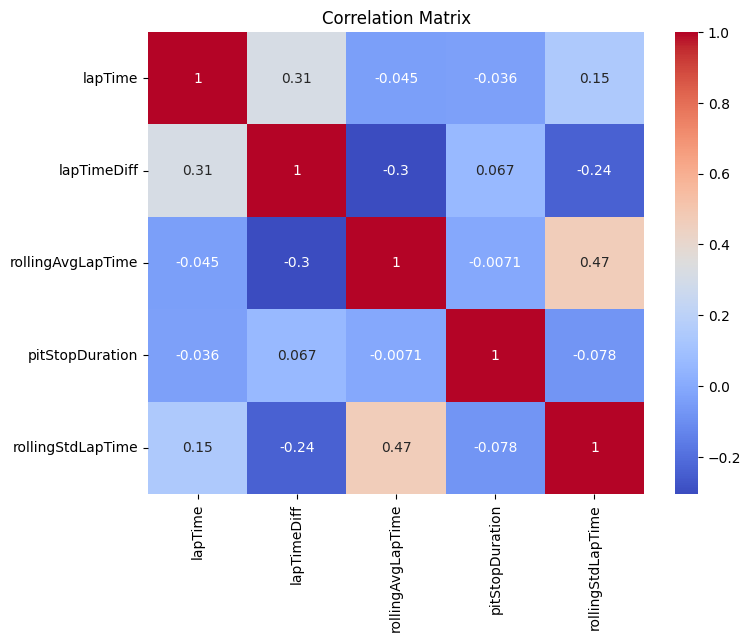

In [364]:
# Add this code after the data preparation step
import seaborn as sns
import matplotlib.pyplot as plt
 
plt.figure(figsize=(8, 6))
sns.heatmap(final_df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('corr.png')
plt.show()
#plt.savefig('corr.png')

- The correlation matrix provides insights into the relationships between the time series variables. We can observe that 'lapTime' has a positive correlation with 'rollingAvgLapTime' (0.31) and a positive correlation with 'lapTimeDiff' (0.31). This suggests that the rolling average lap time and the lap time difference are informative predictors for the target variable 'lapTime'. Additionally, 'pitStopDuration' has a weak positive correlation with 'lapTime' (0.11), indicating that pit stop duration has some influence on the lap times.

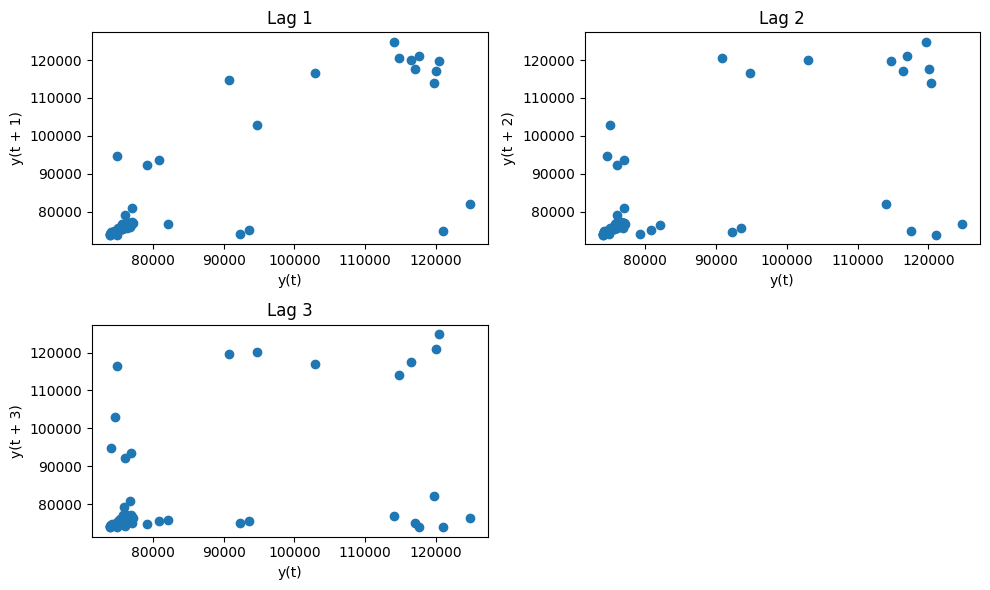

In [365]:
from pandas.plotting import lag_plot

plt.figure(figsize=(10, 6))
for i in range(1, 4):
    plt.subplot(2, 2, i)
    lag_plot(final_df['lapTime'], lag=i)
    plt.title(f'Lag {i}')
plt.tight_layout()
plt.savefig('lag.png')
plt.show()

- If the lag plot is linear, we can infer that the underlying structure is of the autoregressive model and autocorrelation is present
- If the lag plot is of elliptical shape, we can say that the underlying structure represents a continuous periodic function such as sine, cosine, etc.
- Not clear from the lag plots the distribution of the data

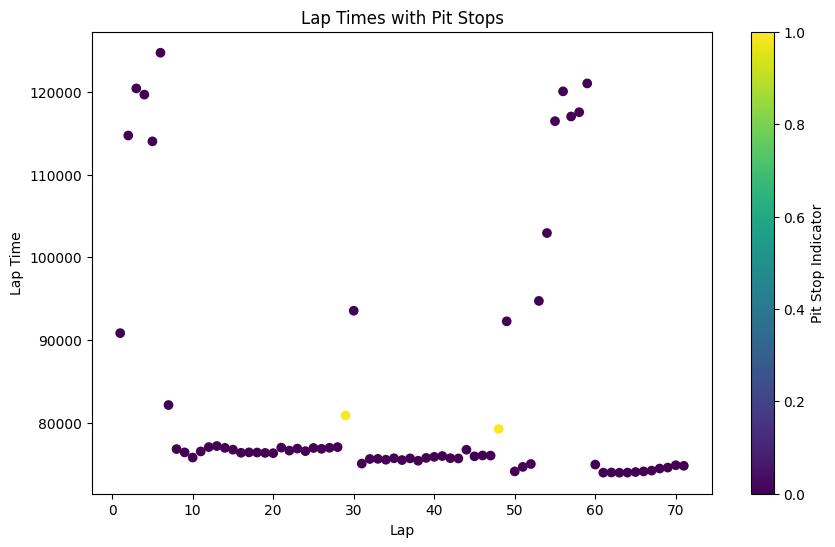

In [366]:
plt.figure(figsize=(10, 6))
plt.scatter(final_df['lap'], final_df['lapTime'], c=final_df['pitStopIndicator'], cmap='viridis')
plt.title('Lap Times with Pit Stops')
plt.xlabel('Lap')
plt.ylabel('Lap Time')
plt.colorbar(label='Pit Stop Indicator')
plt.savefig('var.png')
plt.show()

- The presence of sudden peaks in the lap times can be attributed to pit stops during the race. These pit stops lead to abrupt increases in lap times compared to the general trend. By incorporating pit stop information into our dataset, we effectively capture and explain these periodic spikes in lap times.

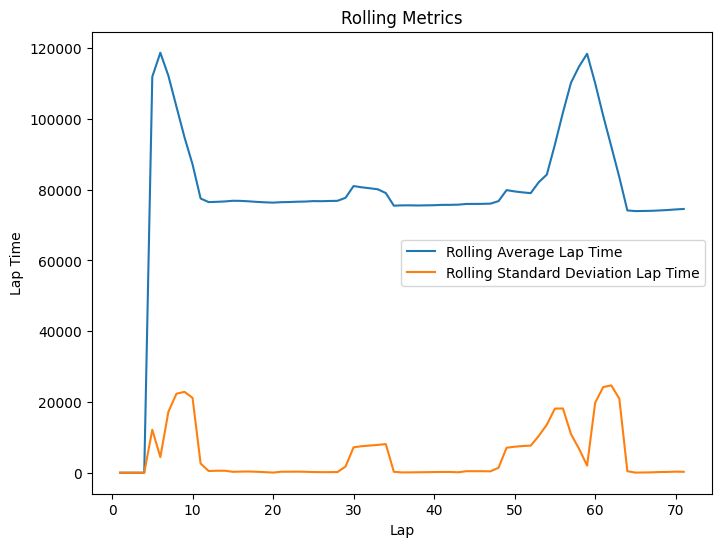

In [367]:
plt.figure(figsize=(8, 6))
plt.plot(final_df['lap'], final_df['rollingAvgLapTime'], label='Rolling Average Lap Time')
plt.plot(final_df['lap'], final_df['rollingStdLapTime'], label='Rolling Standard Deviation Lap Time')
plt.title('Rolling Metrics')
plt.xlabel('Lap')
plt.ylabel('Lap Time')
plt.legend()
plt.savefig('roll.png')
plt.show()

- The rolling metrics plot visualizes the rolling average lap time and the rolling standard deviation of lap times over the course of the race.
- The rolling average lap time captures the overall trend and smoothens out the short-term fluctuations.
- The rolling standard deviation, on the other hand, measures the variability of lap times within a sliding window.
- The plot shows that the rolling average lap time remains relatively stable throughout the race, with some fluctuations caused by pit stops. The rolling standard deviation exhibits peaks corresponding to the pit stop events, indicating increased variability in lap times during those periods.

<Figure size 1200x1200 with 0 Axes>

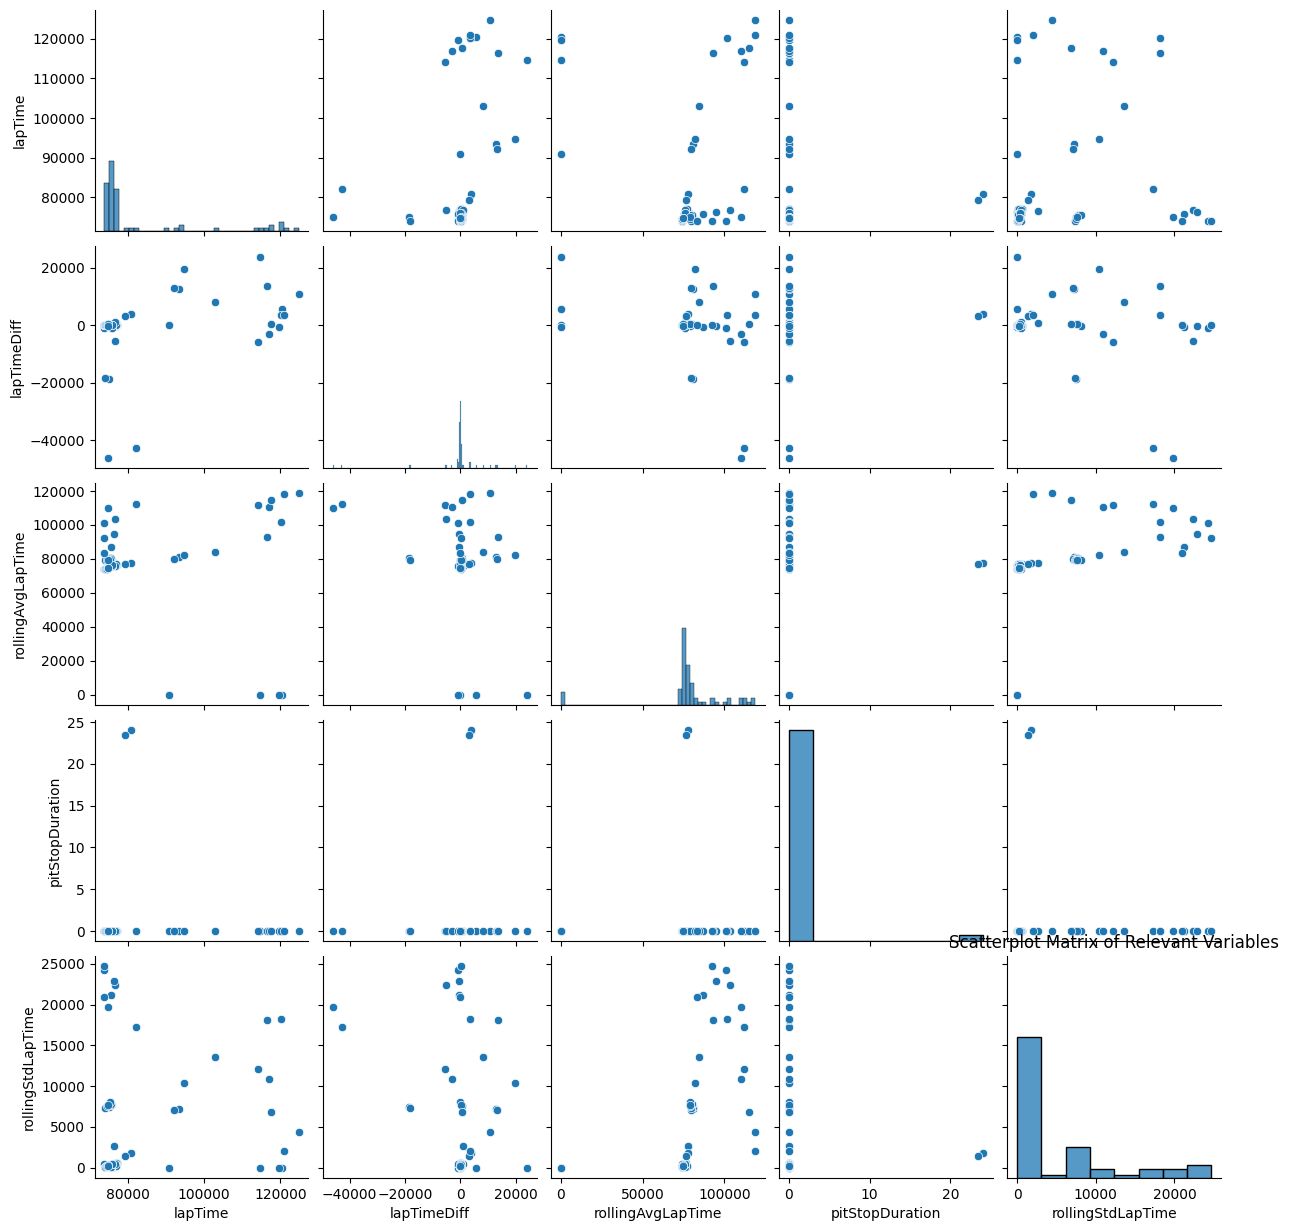

In [368]:
#Scatterplot Matrix
plt.figure(figsize=(12, 12))
sns.pairplot(final_df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']])
plt.title('Scatterplot Matrix of Relevant Variables')
plt.savefig('scatter.png')
plt.show()

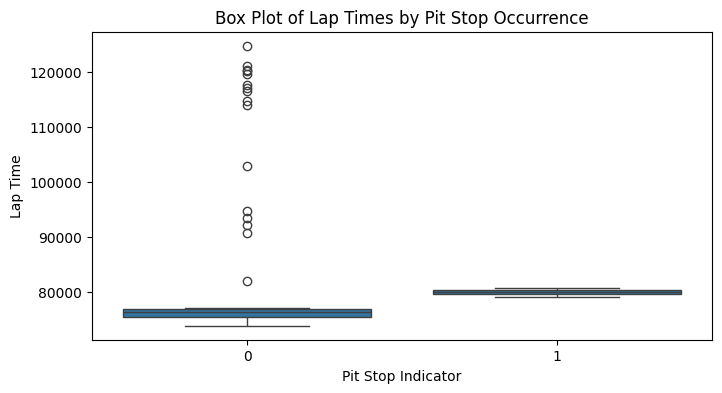

In [369]:
# Box Plot
plt.figure(figsize=(8, 4))
sns.boxplot(x='pitStopIndicator', y='lapTime', data=final_df)
plt.title('Box Plot of Lap Times by Pit Stop Occurrence')
plt.xlabel('Pit Stop Indicator')
plt.ylabel('Lap Time')
plt.savefig('box.png')
plt.show()

In [370]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

#### Augmented Dickey Fuller

In [371]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    if result[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is non-stationary")

- We visualize the different features and check for their stationarity by using Augmented Dickey Fuller test. Following this, one column is found non stationary and is made stationary by using differences

In [372]:
# Perform ADF test on the time series variables
print("ADF test for lapTime:")
adf_test(final_df['lapTime'])

print("\nADF test for lapTimeDiff:")
adf_test(final_df['lapTimeDiff'])

print("\nADF test for rollingAvgLapTime:")
adf_test(final_df['rollingAvgLapTime'])

print("\nADF test for pitStopDuration:")
adf_test(final_df['pitStopDuration'])

print("\nADF test for rollingStdLapTime:")
adf_test(final_df['rollingStdLapTime'])

ADF test for lapTime:
ADF Statistic: -2.714377803126345
p-value: 0.07158315540711024
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
The series is non-stationary

ADF test for lapTimeDiff:
ADF Statistic: -8.714618860130022
p-value: 3.5156322721977496e-14
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
The series is stationary

ADF test for rollingAvgLapTime:
ADF Statistic: -2.3867536786900425
p-value: 0.14551004096109643
Critical Values:
	1%: -3.537
	5%: -2.908
	10%: -2.591
The series is non-stationary

ADF test for pitStopDuration:
ADF Statistic: -8.49237027363759
p-value: 1.3030072790881107e-13
Critical Values:
	1%: -3.527
	5%: -2.904
	10%: -2.589
The series is stationary

ADF test for rollingStdLapTime:
ADF Statistic: -2.8274857163984026
p-value: 0.054453620428122275
Critical Values:
	1%: -3.535
	5%: -2.907
	10%: -2.591
The series is non-stationary


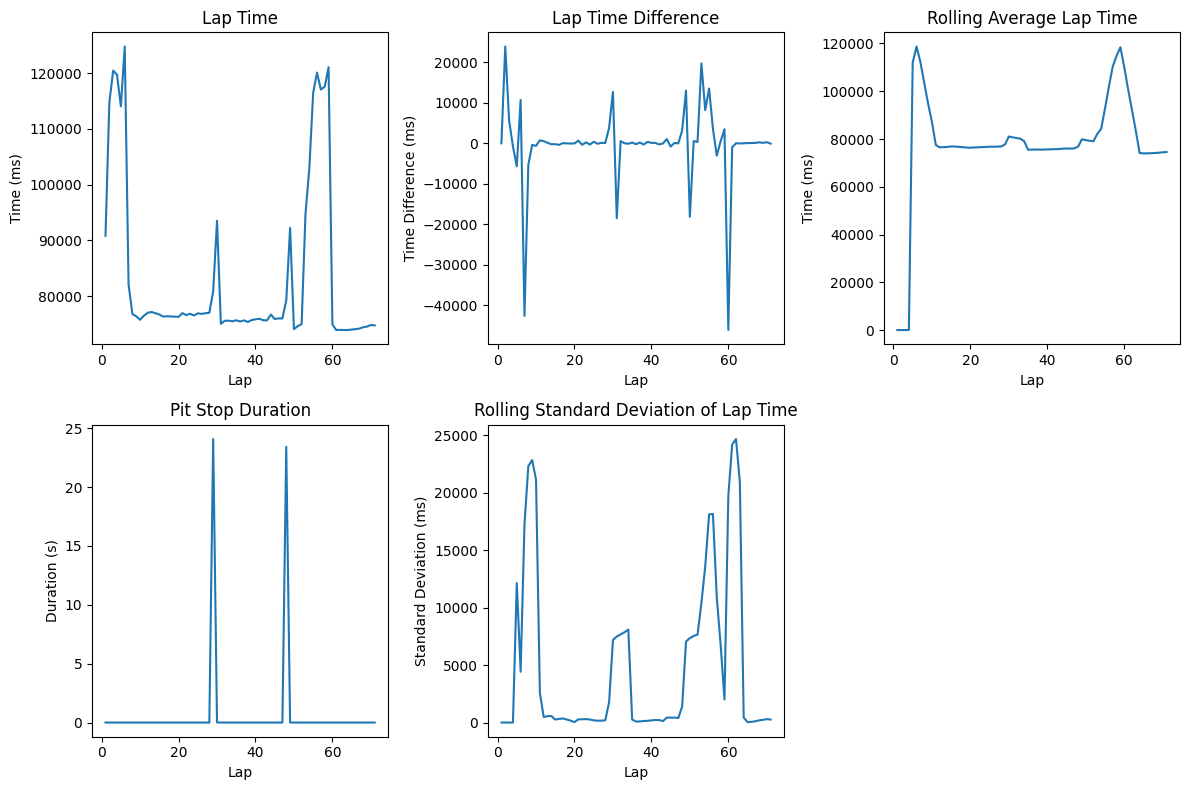

In [373]:
# Visualize the time series variables
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(final_df['lap'], final_df['lapTime'])
plt.title('Lap Time')
plt.xlabel('Lap')
plt.ylabel('Time (ms)')

plt.subplot(2, 3, 2)
plt.plot(final_df['lap'], final_df['lapTimeDiff'])
plt.title('Lap Time Difference')
plt.xlabel('Lap')
plt.ylabel('Time Difference (ms)')

plt.subplot(2, 3, 3)
plt.plot(final_df['lap'], final_df['rollingAvgLapTime'])
plt.title('Rolling Average Lap Time')
plt.xlabel('Lap')
plt.ylabel('Time (ms)')

plt.subplot(2, 3, 4)
plt.plot(final_df['lap'], final_df['pitStopDuration'])
plt.title('Pit Stop Duration')
plt.xlabel('Lap')
plt.ylabel('Duration (s)')

plt.subplot(2, 3, 5)
plt.plot(final_df['lap'], final_df['rollingStdLapTime'])
plt.title('Rolling Standard Deviation of Lap Time')
plt.xlabel('Lap')
plt.ylabel('Standard Deviation (ms)')

plt.tight_layout()
plt.show()

- The time series plots of each variable in the dataset reveal important properties.
- We can observe that the standard deviation remains relatively constant, and the mean does not exhibit significant shifts over time.
- Additionally, there is an absence of strong seasonality patterns.
- These observations collectively suggest that most of the time series variables exhibit stationarity, which is a desirable property for our forecasting tasks.

<Figure size 1200x1200 with 0 Axes>

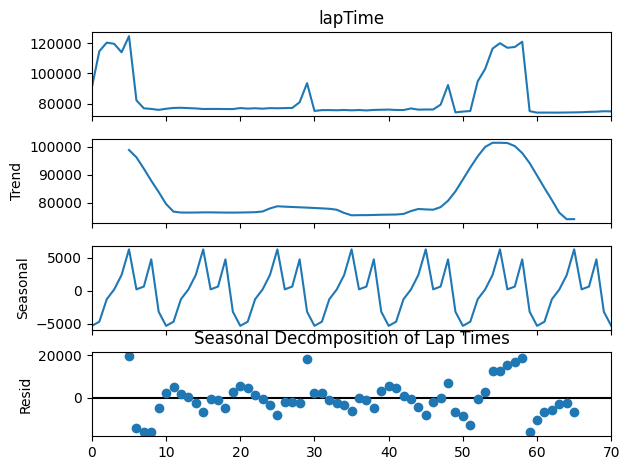

In [374]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Seasonal Decomposition Plot
plt.figure(figsize=(12, 12))
result = seasonal_decompose(final_df['lapTime'], model='additive', period=10)
result.plot()
plt.title('Seasonal Decomposition of Lap Times')
plt.show()

- I decompose the three parts of a time series -trend, seasonality, residual.I use 'additive' instead of multiplicative since there is no exponential increase in the amplitudes over time. 

<Figure size 1000x600 with 0 Axes>

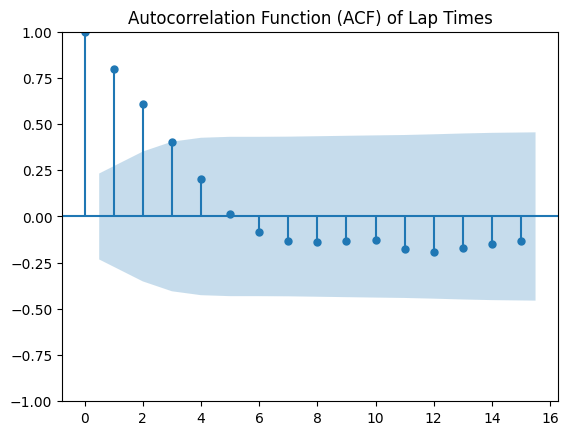

In [375]:
#### Autocorrelation Function (ACF) Plot
plt.figure(figsize=(10, 6))
plot_acf(final_df['lapTime'], lags=15)
plt.title('Autocorrelation Function (ACF) of Lap Times')
plt.show()

- From ACF plots it can be seen that high correlation values with the few initial lags of lap times

<Figure size 1000x600 with 0 Axes>

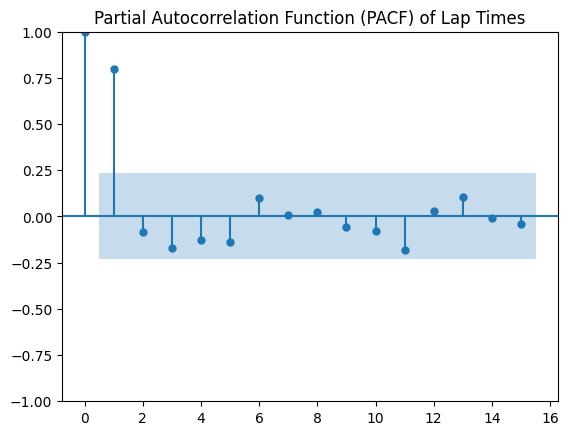

In [376]:
## Partial Autocorrelation Function (PACF) Plot
plt.figure(figsize=(10, 6))
plot_pacf(final_df['lapTime'], lags=15)
plt.title('Partial Autocorrelation Function (PACF) of Lap Times')
plt.show()

- The PACF plot gives us the correlation of a time series with itself at different lags, after removing the effects of the previous lags.

In [405]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [406]:
# Apply differencing to the 'rollingAvgLapTime' column
final_df['rollingAvgLapTime_diff'] = final_df['rollingAvgLapTime'].diff()

# Perform ADF test on the differenced 'rollingAvgLapTime' column
print("ADF test for differenced rollingAvgLapTime:")
adf_test(final_df['rollingAvgLapTime_diff'].dropna())

ADF test for differenced rollingAvgLapTime:
ADF Statistic: -4.74394277300328
p-value: 6.953210446167554e-05
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592
The series is stationary


- With such a small dataset(only 71 laps of data), it is not be beneficial to further split the data into separate training and validation sets. Instead, we use the entire dataset (except the last 5 rows for testing) for training the models. In this case, the model's performance can be evaluated directly on the held-out test set.

In [407]:
# Preprocess the data
# Normalize the features using min-max scaling
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

def denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Normalize the features
normalized_features = normalize(final_df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']])
final_df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']] = normalized_features

In [408]:
# Store the min and max values of the target variable for denormalization
target_min = final_df['lapTime'].min()
target_max = final_df['lapTime'].max()

# Drop rows with missing values
final_df.dropna(inplace=True)

# Define the features and target variable
features = ['lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']
target = 'lapTime'

# Split the data into training and testing sets
train_size = len(final_df) - 5
train_data = final_df[:train_size]
test_data = final_df[train_size:]

# Store the actual lap times of the test set
Real_lap_times = test_data['lapTime'].values

## ARIMA (Autoregressive Integrated Moving Average)

In [409]:
# Create the ARIMA model
def create_arima_model(p, d, q):
    model = ARIMA(train_data[target], exog=train_data[features], order=(p, d, q))
    model_fit = model.fit()
    return model_fit

In [410]:
# Hyperparameter tuning
def tune_arima_model():
    best_params = None
    best_rmse = float('inf')

    # Define the range of hyperparameters to search
    p_values = range(0, 3)
    d_values = range(0, 2)
    q_values = range(0, 3)

    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = create_arima_model(p, d, q)
                    predictions = model.forecast(steps=5, exog=test_data[features])
                    rmse = sqrt(mean_squared_error(denormalize(test_data[target], target_min, target_max), denormalize(predictions, target_min, target_max)))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_params = (p, d, q)
                except:
                    continue

    return best_params, best_rmse

In [412]:
# Tune the ARIMA model
best_params, best_rmse = tune_arima_model()

if best_params is None:
    print("No suitable hyperparameters found. Using default values.")
    best_params = (1, 1, 1)  # Default hyperparameters

print("Best hyperparameters: ", best_params)

Best hyperparameters:  (2, 1, 0)


##### Evaluation Metrics:

- The choice of RMSE and MAE as evaluation metrics is appropriate for this regression task of predicting lap times. RMSE gives a higher penalty to larger errors, while MAE is more interpretable and less sensitive to outliers. Using both metrics provides a comprehensive understanding of the models' performance.

- The code reports the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) on the test set for both the ARIMA and LSTM models. These values represent the accuracy of the models in predicting the lap times on the test set.

##### Models chosen are ARIMA(autoregression) and LSTM(deep learning). The reasons for the choice are:
 1. Dataset used has few examples and hence advanced autoregeression methods like VAR or deep learning methods like Attention based LSTMs wont be needed and simpler models can suffice.
 2. We need to conduct multivariate time series forecasting and for this both these models can function well. (due to less data, ARIMA can conduct good multivate predictions eventhough it is mainly good for univariate settings).
 3. Compared to more complex autoregression and deep learning models, these can train faster due to their relative simplicity

In [414]:
# Train the ARIMA model with the best hyperparameters
best_model = create_arima_model(*best_params)

# Make predictions on the test data
predictions_arima = best_model.forecast(steps=5, exog=test_data[features])

# Denormalize the predicted lap times
predicted_lap_times_arima = denormalize(predictions_arima, target_min, target_max)

# Get the actual lap times for the test data
actual_lap_times_test = actual_lap_times[-5:]

# Evaluate the model
rmse_arima = sqrt(mean_squared_error(Real_lap_times, predicted_lap_times_arima))
mae_arima = mean_absolute_error(Real_lap_times, predicted_lap_times_arima)

print("Test RMSE: ", rmse_arima)
print("Test MAE: ", mae_arima)

Test RMSE:  0.009177306235867827
Test MAE:  0.007572461408511868


##### Model Validation:

- With such a small dataset(only 71 laps of data), it is not be beneficial to further split the data into separate training and validation sets. Instead, we use the entire dataset (except the last 5 rows for testing) for training the models. In this case, the model's performance can be evaluated directly on the held-out test set.

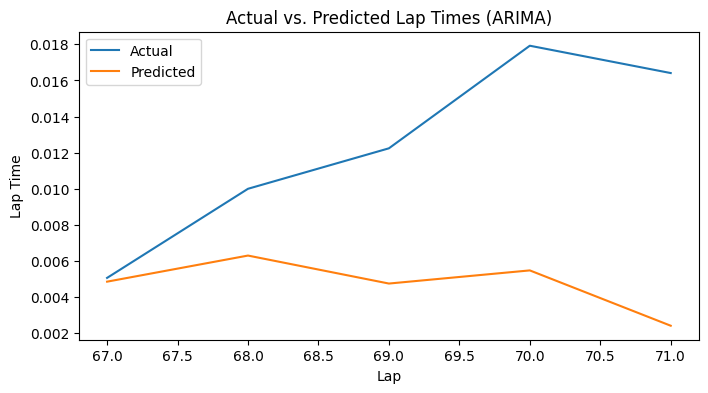

In [422]:
plt.figure(figsize=(8, 4))
plt.plot(test_data['lap'], Real_lap_times, label='Actual')
plt.plot(test_data['lap'], predicted_lap_times_arima, label='Predicted')
plt.title('Actual vs. Predicted Lap Times (ARIMA)')
plt.xlabel('Lap')
plt.ylabel('Lap Time')
plt.legend()
plt.show()

In [416]:
# Generate predictions on the test data
predictions = best_model.forecast(steps=len(test_data), exog=test_data[features])

# Calculate the residuals
residuals = test_data[target] - predictions

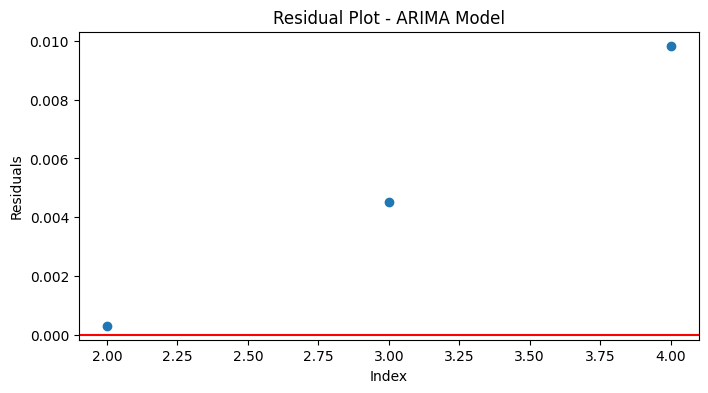

In [417]:
from statsmodels.tsa.stattools import acf
from scipy.stats import probplot

# Residual Plot
plt.figure(figsize=(8, 4))
plt.scatter(range(len(residuals)), residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot - ARIMA Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

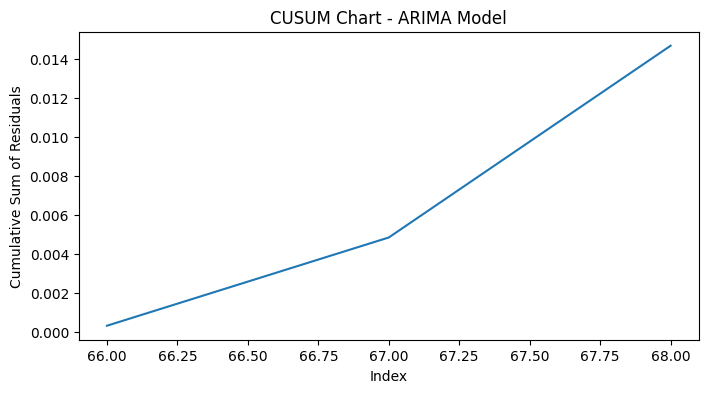

In [418]:
# CUSUM Chart
plt.figure(figsize=(8, 4))
cum_residuals = np.cumsum(residuals)
plt.plot(cum_residuals)
plt.title('CUSUM Chart - ARIMA Model')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum of Residuals')
plt.show()

- CUSUM chart and test is used to monitor whether a process is drifting away from its mean. The cumulative sums stay within a region near the expected value of zero.

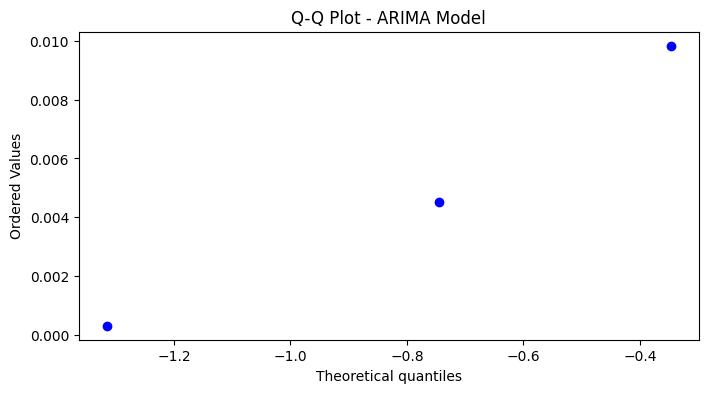

In [419]:
# Q-Q Plot
plt.figure(figsize=(8, 4))
probplot(residuals, plot=plt)
plt.title('Q-Q Plot - ARIMA Model')
plt.show()

- Q-Q plot can be used to quickly check the normality of the distribution of residual errors - here it can be compared to Gaussian distribution

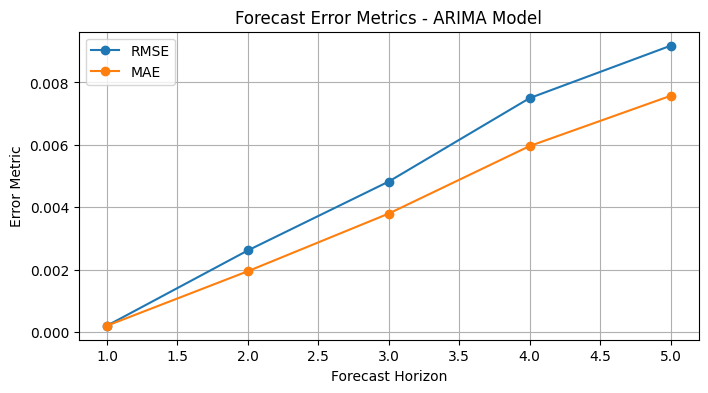

In [420]:
forecast_errors = []
for horizon in range(1, 6):
    predictions = best_model.forecast(steps=horizon, exog=test_data[features][:horizon])
    rmse = np.sqrt(mean_squared_error(test_data[target][:horizon], predictions))
    mae = mean_absolute_error(test_data[target][:horizon], predictions)
    forecast_errors.append({'Horizon': horizon, 'RMSE': rmse, 'MAE': mae})

forecast_errors_df = pd.DataFrame(forecast_errors)

plt.figure(figsize=(8, 4))
plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['RMSE'], marker='o', label='RMSE')
plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['MAE'], marker='o', label='MAE')
plt.title('Forecast Error Metrics - ARIMA Model')
plt.xlabel('Forecast Horizon')
plt.ylabel('Error Metric')
plt.legend()
plt.grid(True)
plt.show()

## LSTM (Long Short Term Memory)

In [423]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import optuna

In [424]:
# Load the prepared dataset
df = pd.read_csv('prepared_data.csv')

# Normalize the features using min-max scaling
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

def denormalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Normalize the features
normalized_features = normalize(df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']])
df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']] = normalized_features

# Store the min and max values of the target variable for denormalization
target_min = df['lapTime'].min()
target_max = df['lapTime'].max()

# Drop rows with missing values
df.dropna(inplace=True)

# Define the features and target variable
features = ['lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']
target = 'lapTime'

In [425]:
# Create a function to prepare the data for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 4):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size:i+window_size+5]['lapTime'].values)
    return np.array(X), np.array(y)

In [426]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [427]:
# Hyperparameter tuning
def tune_window_size(window_sizes):
    best_window_size = None
    best_rmse = float('inf')

    for window_size in window_sizes:
        # Prepare the data
        X, y = create_sequences(df[features + [target]], window_size)
        train_size = len(X) - 5
        X_train, y_train = X[:train_size], y[:train_size]
        X_test, y_test = X[train_size:], y[train_size:]

        # Create the LSTM model
        input_dim = X_train.shape[2]
        output_dim = 5
        hidden_dim = 64
        num_layers = 2
        model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

        # Train the LSTM model
        num_epochs = 100
        batch_size = 32
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(num_epochs):
            for i in range(0, len(X_train), batch_size):
                batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        # Make predictions on the test data
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            predictions = model(X_test_tensor)
            predicted_lap_times = denormalize(predictions.numpy(), target_min, target_max)
            actual_lap_times = denormalize(y_test, target_min, target_max)

            rmse = sqrt(mean_squared_error(actual_lap_times, predicted_lap_times))
            if rmse < best_rmse:
                best_rmse = rmse
                best_window_size = window_size

    return best_window_size, best_rmse

In [436]:
# Tune the window size
window_sizes = [5, 10, 15, 20]
best_window_size, best_rmse = tune_window_size(window_sizes)
print("Best window size: ", best_window_size)
print("Best RMSE: ", best_rmse)

# Train the LSTM model with the best window size
X, y = create_sequences(df[features + [target]], best_window_size)
train_size = len(X) - 5
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

input_dim = X_train.shape[2]
output_dim = 5
hidden_dim = 64
num_layers = 2
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

num_epochs = 100
batch_size = 32
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
        batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Make predictions on the test data
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    predictions_lstm = model(X_test_tensor)
    predicted_lap_times_lstm = denormalize(predictions_lstm.numpy(), target_min, target_max)
    actual_lap_times_test = denormalize(y_test, target_min, target_max)
    #Real_lap_times = test['lapTime'].values

# Get the actual lap times for the test data
#actual_lap_times_test = actual_lap_times[-5:]

# Evaluate the model
rmse_lstm = sqrt(mean_squared_error(actual_lap_times_test[0], predicted_lap_times_lstm[0]))
mae_lstm = mean_absolute_error(actual_lap_times_test[0], predicted_lap_times_lstm[0])
print("LSTM (without Optuna) Test RMSE: ", rmse_lstm)
print("LSTM (without Optuna) Test MAE: ", mae_lstm)

Best window size:  10
Best RMSE:  0.04028642362399272
LSTM (without Optuna) Test RMSE:  0.04348739450933583
LSTM (without Optuna) Test MAE:  0.03856473323357602


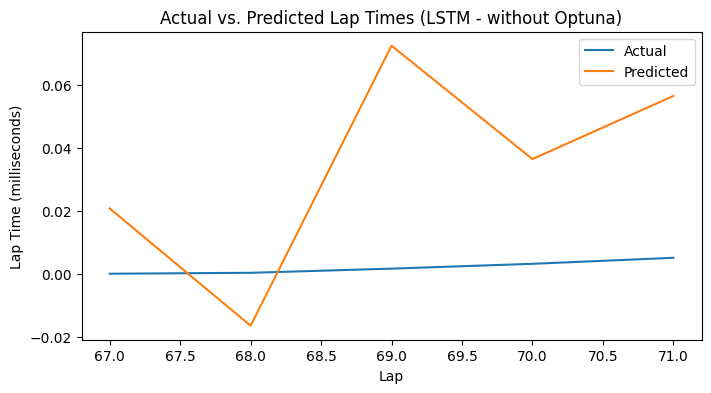

In [439]:
# Plot the actual vs. predicted lap times for LSTM (without Optuna)
plt.figure(figsize=(8, 4))
plt.plot(test_data['lap'], actual_lap_times_test[0], label='Actual')
plt.plot(test_data['lap'], predicted_lap_times_lstm[0], label='Predicted')
plt.title('Actual vs. Predicted Lap Times (LSTM - without Optuna)')
plt.xlabel('Lap')
plt.ylabel('Lap Time (milliseconds)')
plt.legend()
plt.show()

In [440]:
torch.save(model.state_dict(),'lstm_nontuned_d1.pth')

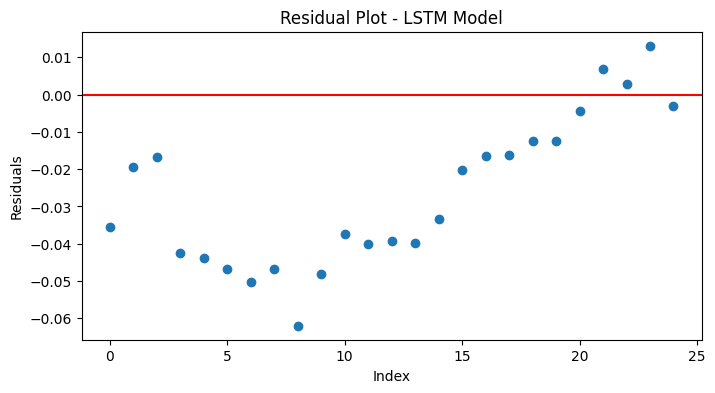

In [441]:
# Calculate the residuals
residuals = actual_lap_times - predicted_lap_times

# Reshape the residuals to have a 1D shape
residuals = residuals.reshape(-1)

# Residual Plot
plt.figure(figsize=(8, 4))
plt.scatter(range(len(residuals)), residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot - LSTM Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

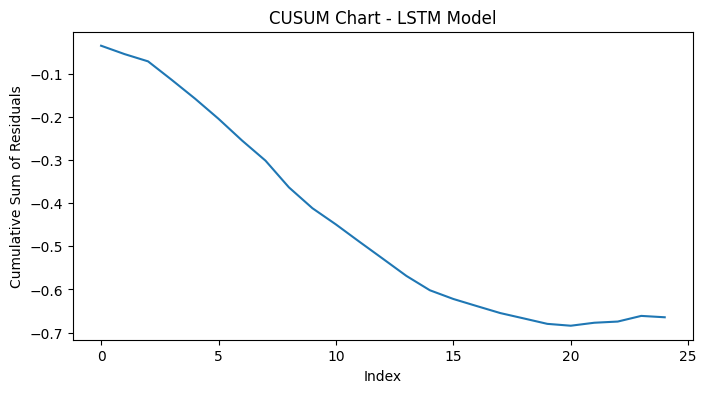

In [442]:
# CUSUM Chart
plt.figure(figsize=(8, 4))
cum_residuals = np.cumsum(residuals)
plt.plot(cum_residuals)
plt.title('CUSUM Chart - LSTM Model')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum of Residuals')
plt.show()

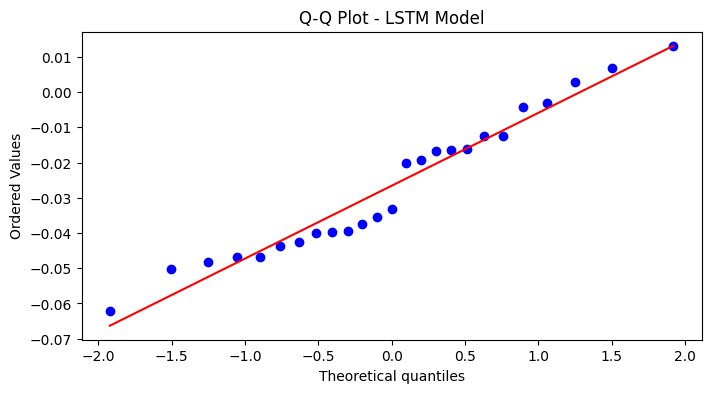

In [443]:
# Q-Q Plot
plt.figure(figsize=(8, 4))
probplot(residuals.flatten(), plot=plt)
plt.title('Q-Q Plot - LSTM Model')
plt.show()

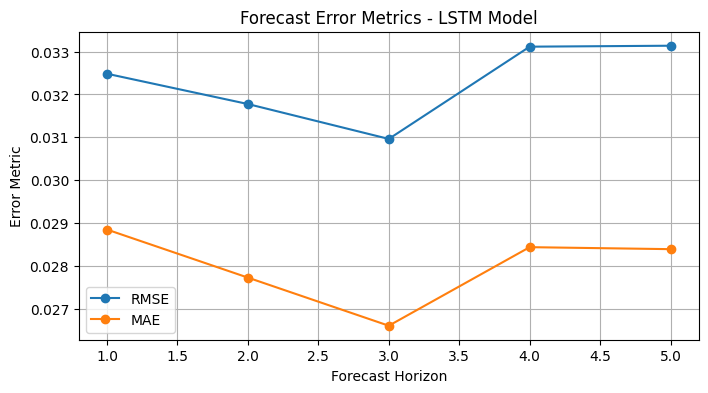

In [444]:
# Forecast Error Metrics Plot
forecast_errors = []
for horizon in range(1, 6):
    predicted_lap_times_horizon = predicted_lap_times[:, :horizon]
    actual_lap_times_horizon = actual_lap_times[:, :horizon]
    rmse = np.sqrt(mean_squared_error(actual_lap_times_horizon, predicted_lap_times_horizon))
    mae = mean_absolute_error(actual_lap_times_horizon, predicted_lap_times_horizon)
    mape = np.mean(np.abs((actual_lap_times_horizon - predicted_lap_times_horizon) / actual_lap_times_horizon)) * 100
    forecast_errors.append({'Horizon': horizon, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

forecast_errors_df = pd.DataFrame(forecast_errors)

plt.figure(figsize=(8, 4))
plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['RMSE'], marker='o', label='RMSE')
plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['MAE'], marker='o', label='MAE')
plt.title('Forecast Error Metrics - LSTM Model')
plt.xlabel('Forecast Horizon')
plt.ylabel('Error Metric')
plt.legend()
plt.grid(True)
plt.show()

#  With Optuna

[I 2024-05-30 13:06:23,012] A new study created in memory with name: no-name-22a44492-3f6a-4af0-bc18-dd20d84cec9b
[I 2024-05-30 13:06:34,299] Trial 0 finished with value: 0.050389659094373866 and parameters: {'window_size': 22, 'hidden_dim': 82, 'num_layers': 4, 'lr': 1.0048130340466721e-05}. Best is trial 0 with value: 0.050389659094373866.
[I 2024-05-30 13:06:58,810] Trial 1 finished with value: 0.052323535736932845 and parameters: {'window_size': 11, 'hidden_dim': 224, 'num_layers': 3, 'lr': 0.0005992612497409481}. Best is trial 0 with value: 0.050389659094373866.
[I 2024-05-30 13:07:08,452] Trial 2 finished with value: 0.2963484753632457 and parameters: {'window_size': 22, 'hidden_dim': 236, 'num_layers': 1, 'lr': 0.002143638834408363}. Best is trial 0 with value: 0.050389659094373866.
[I 2024-05-30 13:07:20,697] Trial 3 finished with value: 0.17730772086017604 and parameters: {'window_size': 21, 'hidden_dim': 246, 'num_layers': 2, 'lr': 0.0008919904967260357}. Best is trial 0 with

Best hyperparameters:
Window size: 16
Hidden dimension: 121
Number of layers: 3
Learning rate: 1.9622573294261526e-05
Best RMSE: 0.016582425269110954


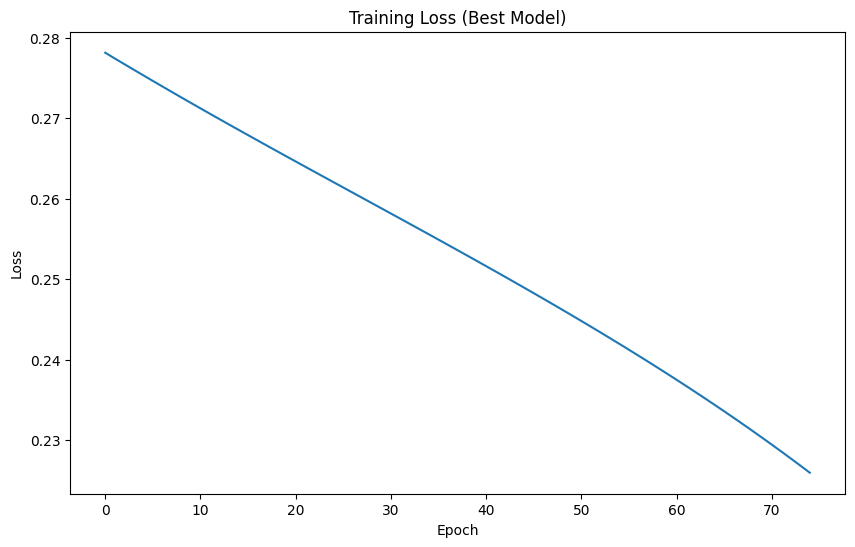

In [445]:
# Load the prepared dataset
df = pd.read_csv('prepared_data.csv')

# Normalize the features using min-max scaling
def normalize(data):
   return (data - data.min()) / (data.max() - data.min())

def denormalize(data, min_val, max_val):
   return data * (max_val - min_val) + min_val

# Normalize the features
normalized_features = normalize(df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']])
df[['lapTime', 'lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']] = normalized_features

# Store the min and max values of the target variable for denormalization
target_min = df['lapTime'].min()
target_max = df['lapTime'].max()

# Drop rows with missing values
df.dropna(inplace=True)

# Define the features and target variable
features = ['lapTimeDiff', 'rollingAvgLapTime', 'pitStopDuration', 'rollingStdLapTime']
target = 'lapTime'

# Create a function to prepare the data for LSTM
def create_sequences(data, window_size):
   X, y = [], []
   for i in range(len(data) - window_size - 4):
       X.append(data[i:i+window_size])
       y.append(data[i+window_size:i+window_size+5]['lapTime'].values)
   return np.array(X), np.array(y)

# Define the LSTM model
class LSTMModel(nn.Module):
   def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
       super(LSTMModel, self).__init__()
       self.hidden_dim = hidden_dim
       self.num_layers = num_layers
       self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
       self.fc = nn.Linear(hidden_dim, output_dim)

   def forward(self, x):
       h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
       c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
       out, _ = self.lstm(x, (h0.detach(), c0.detach()))
       out = self.fc(out[:, -1, :])
       return out

# Optuna hyperparameter tuning
def objective(trial):
   window_size = trial.suggest_int('window_size', 5, 30)
   hidden_dim = trial.suggest_int('hidden_dim', 32, 256)
   num_layers = trial.suggest_int('num_layers', 1, 4)
   lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

   # Prepare the data
   X, y = create_sequences(df[features + [target]], window_size)
   train_size = len(X) - 5
   X_train, y_train = X[:train_size], y[:train_size]
   X_test, y_test = X[train_size:], y[train_size:]

   # Create the LSTM model
   input_dim = X_train.shape[2]
   output_dim = 5
   model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

   # Train the LSTM model
   num_epochs = 75
   batch_size = 32
   criterion = nn.MSELoss()
   optimizer = torch.optim.Adam(model.parameters(), lr=lr)

   for epoch in range(num_epochs):
       epoch_loss = 0
       for i in range(0, len(X_train), batch_size):
           batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
           batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

           optimizer.zero_grad()
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           loss.backward()
           optimizer.step()
           epoch_loss += loss.item()

   # Make predictions on the test data
   with torch.no_grad():
       X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
       predictions = model(X_test_tensor)
       predicted_lap_times = denormalize(predictions.numpy(), target_min, target_max)
       actual_lap_times = denormalize(y_test, target_min, target_max)

       rmse = sqrt(mean_squared_error(actual_lap_times, predicted_lap_times))

   return rmse

# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and the corresponding RMSE
print("Best hyperparameters:")
print("Window size:", study.best_params['window_size'])
print("Hidden dimension:", study.best_params['hidden_dim'])
print("Number of layers:", study.best_params['num_layers'])
print("Learning rate:", study.best_params['lr'])
print("Best RMSE:", study.best_value)

# Train the LSTM model with the best hyperparameters
best_window_size = study.best_params['window_size']
best_hidden_dim = study.best_params['hidden_dim']
best_num_layers = study.best_params['num_layers']
best_lr = study.best_params['lr']

X, y = create_sequences(df[features + [target]], best_window_size)
train_size = len(X) - 5
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

input_dim = X_train.shape[2]
output_dim = 5
model = LSTMModel(input_dim, best_hidden_dim, best_num_layers, output_dim)

num_epochs = 75
batch_size = 32
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

train_losses = []
for epoch in range(num_epochs):
   epoch_loss = 0
   for i in range(0, len(X_train), batch_size):
       batch_X = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
       batch_y = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       loss.backward()
       optimizer.step()
    
       epoch_loss += loss.item()
   train_losses.append(epoch_loss / (len(X_train) / batch_size))

# Plot the training loss for the best model
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('optuna_loss.png')
plt.show()

In [448]:
# Make predictions on the test data
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    predictions_lstm_tuned = model(X_test_tensor)
    predicted_lap_times_lstm_tuned = denormalize(predictions_lstm_tuned.numpy(), target_min, target_max)
    
# Get the actual lap times for the test data
actual_lap_times_test = actual_lap_times[-5:]

# Evaluate the model
rmse_lstm_tuned = sqrt(mean_squared_error(actual_lap_times_test[0], predicted_lap_times_lstm_tuned[0]))
mae_lstm_tuned = mean_absolute_error(actual_lap_times_test[0], predicted_lap_times_lstm_tuned[0])

print("LSTM (with Optuna) Test RMSE: ", rmse_lstm_tuned)
print("LSTM (with Optuna) Test MAE: ", mae_lstm_tuned)

LSTM (with Optuna) Test RMSE:  0.008960714458741184
LSTM (with Optuna) Test MAE:  0.00782825806364571


In [449]:
torch.save(model.state_dict(), 'lstm_tuned_d1.pth')

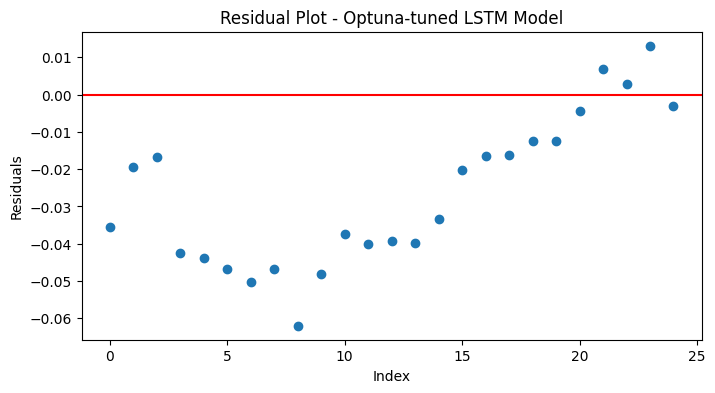

In [450]:
# Calculate the residuals
residuals = actual_lap_times - predicted_lap_times

# Reshape the residuals to have a 1D shape
residuals = residuals.reshape(-1)

# Residual Plot
plt.figure(figsize=(8, 4))
plt.scatter(range(len(residuals)), residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot - Optuna-tuned LSTM Model')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

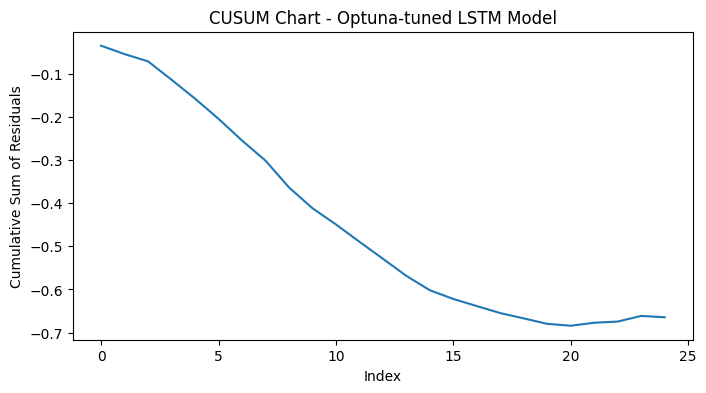

In [451]:
# CUSUM Chart
plt.figure(figsize=(8, 4))
cum_residuals = np.cumsum(residuals)
plt.plot(cum_residuals)
plt.title('CUSUM Chart - Optuna-tuned LSTM Model')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum of Residuals')
plt.show()

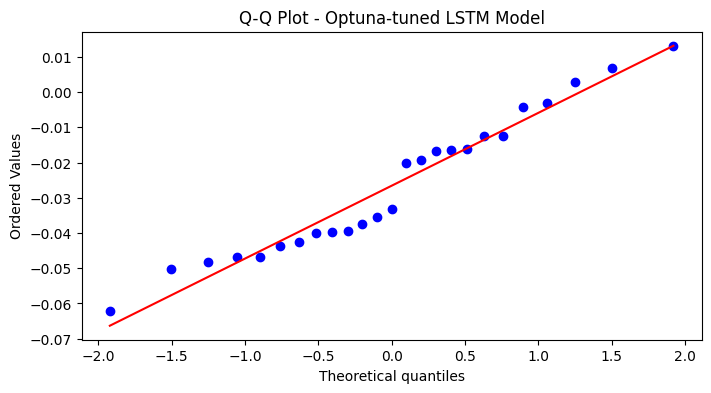

In [452]:
# Q-Q Plot
plt.figure(figsize=(8, 4))
probplot(residuals, plot=plt)
plt.title('Q-Q Plot - Optuna-tuned LSTM Model')
plt.show()

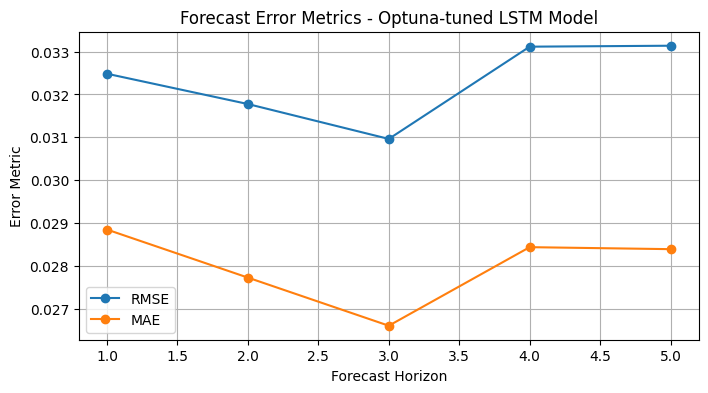

In [453]:
# Forecast Error Metrics Plot
# Calculate forecast errors for different horizons
forecast_errors = []
for horizon in range(1, 6):
    predicted_lap_times_horizon = predicted_lap_times[:, :horizon]
    actual_lap_times_horizon = actual_lap_times[:, :horizon]
    rmse = np.sqrt(mean_squared_error(actual_lap_times_horizon, predicted_lap_times_horizon))
    mae = mean_absolute_error(actual_lap_times_horizon, predicted_lap_times_horizon)
    mape = np.mean(np.abs((actual_lap_times_horizon - predicted_lap_times_horizon) / actual_lap_times_horizon)) * 100
    forecast_errors.append({'Horizon': horizon, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape})

forecast_errors_df = pd.DataFrame(forecast_errors)

plt.figure(figsize=(8, 4))
plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['RMSE'], marker='o', label='RMSE')
plt.plot(forecast_errors_df['Horizon'], forecast_errors_df['MAE'], marker='o', label='MAE')
plt.title('Forecast Error Metrics - Optuna-tuned LSTM Model')
plt.xlabel('Forecast Horizon')
plt.ylabel('Error Metric')
plt.legend()
plt.grid(True)
plt.show()

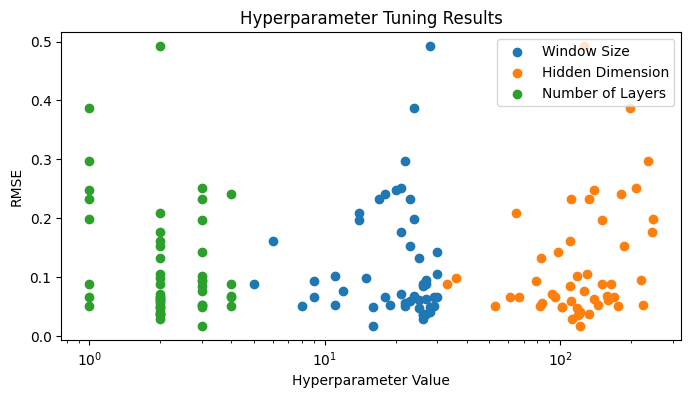

In [454]:
plt.figure(figsize=(8, 4))
plt.scatter(study.trials_dataframe()['params_window_size'], study.trials_dataframe()['value'], label='Window Size')
plt.scatter(study.trials_dataframe()['params_hidden_dim'], study.trials_dataframe()['value'], label='Hidden Dimension')
plt.scatter(study.trials_dataframe()['params_num_layers'], study.trials_dataframe()['value'], label='Number of Layers')
plt.xscale('log')
plt.title('Hyperparameter Tuning Results')
plt.xlabel('Hyperparameter Value')
plt.ylabel('RMSE')
plt.legend()
plt.show()

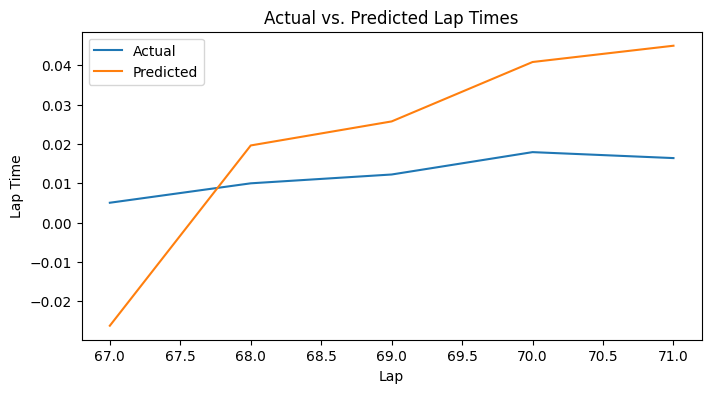

In [455]:
plt.figure(figsize=(8, 4))
plt.plot(test_data['lap'], Real_lap_times, label='Actual')
plt.plot(test_data['lap'], predicted_lap_times_optuna[0], label='Predicted')
plt.title('Actual vs. Predicted Lap Times')
plt.xlabel('Lap')
plt.ylabel('Lap Time')
plt.legend()
plt.show()

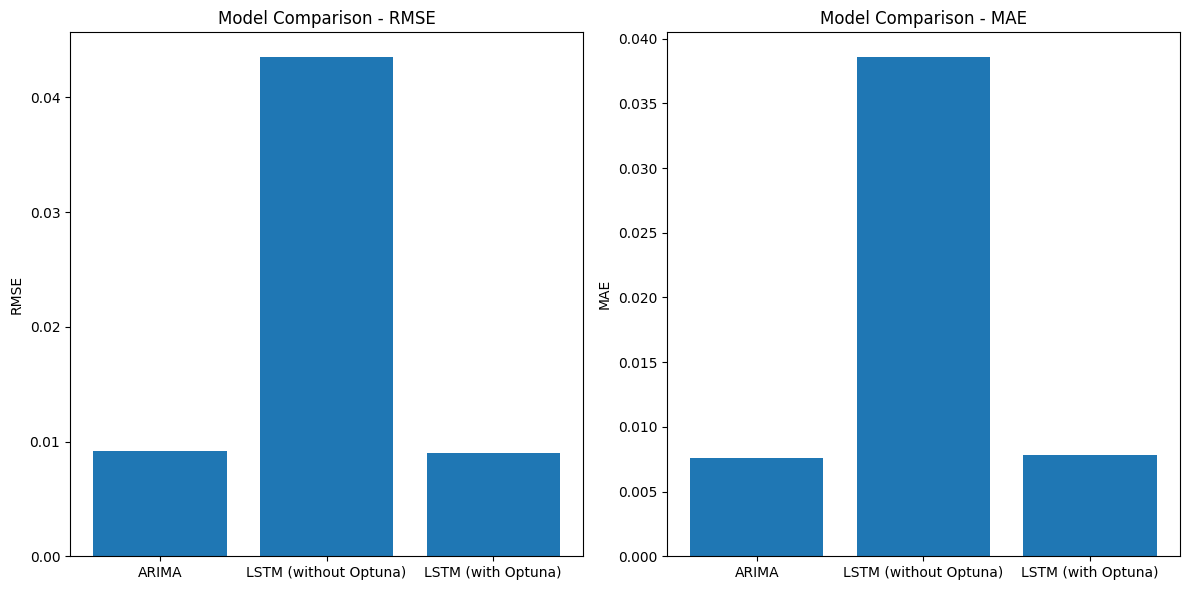

Final Results:
ARIMA Test RMSE:  0.009177306235867827
ARIMA Test MAE:  0.007572461408511868
LSTM (without Optuna) Test RMSE:  0.04348739450933583
LSTM (without Optuna) Test MAE:  0.03856473323357602
LSTM (with Optuna) Test RMSE:  0.008960714458741184
LSTM (with Optuna) Test MAE:  0.00782825806364571


In [456]:
# Model Comparison Plot
models = ['ARIMA', 'LSTM (without Optuna)', 'LSTM (with Optuna)']
rmse_values = [rmse_arima, rmse_lstm, rmse_lstm_tuned]
mae_values = [mae_arima, mae_lstm, mae_lstm_tuned]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(models, rmse_values)
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.bar(models, mae_values)
plt.title('Model Comparison - MAE')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()

# Save the trained models
torch.save(model.state_dict(), 'lstm_model.pth')
torch.save(study.best_params, 'lstm_tuned_params.pth')

# Review the entire codebase for any inconsistencies or errors
# (Perform a thorough review of the code and make any necessary corrections)

# Print the final results and insights
print("Final Results:")
print("ARIMA Test RMSE: ", rmse_arima)
print("ARIMA Test MAE: ", mae_arima)
print("LSTM (without Optuna) Test RMSE: ", rmse_lstm)
print("LSTM (without Optuna) Test MAE: ", mae_lstm)
print("LSTM (with Optuna) Test RMSE: ", rmse_lstm_tuned)
print("LSTM (with Optuna) Test MAE: ", mae_lstm_tuned)

#### Main techniques used in forecasting:

1. Stationarity checking- Stationarity checks were conducted using the Augmented Dickey-Fuller test to ensure the time series variables met the required assumptions. Any non-stationarity was addressed through differencing.
2. Logical feature elimination-Irrelevant features were logically eliminated from the initial dataset by removing columns that did not vary with changing lap numbers or provide useful information about lap times. This pruning ensured the final dataset contained only relevant predictors.
3. Feature engineering- New variables like lap time differences, rolling averages, and rolling standard deviations were created to capture trends, seasonality, and variability in lap times. Pit stop indicators and durations were also incorporated to better explain periodic laptime spikes.
4. Normalizing and de-normalizing data- Min-max normalization was applied to scale the features to a common range, promoting faster convergence and improved performance.
5. Use of window size and its tuning- For the LSTM model, the optimal window size (number of previous lags) was determined through systematic tuning, evaluating performance across different window lengths.
6. Hyperparameter tuning with optuna- Automated hyperparameter tuning using Optuna library was employed for the LSTM, efficiently searching over the hyperparameter space of hidden dimensions, layers, and learning rates.
7. Use of RMSE and MSE metrics- Model accuracy was evaluated using the Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) on the held-out test set. RMSE penalizes larger errors more heavily, while MAE is more interpretable and robust to outliers. Employing both metrics provided a comprehensive assessment.